# Summary and Result from Lobito Corridor Spatial Analysis

## Run once after (re)starting the kernel

<div class="alert alert-block alert-success" align="left">
  <b>Why this cell?</b><br/>
  It initializes the workspace for the current AOI—sets <code>PROJECT_ROOT</code>/<code>AOI</code>, adds <code>src/</code> to <code>sys.path</code>, clears the import cache, and loads <code>config.py</code> so <code>PATHS</code>/<code>PARAMS</code> are available to all steps.
  <br/><br/>
  <b>When to run it</b>
  <ul>
    <li>After a kernel restart (once).</li>
    <li>After changing <code>AOI_VALUE</code> or editing <code>config.py</code> (paths/parameters/templates).</li>
    <li>After moving the project folder.</li>
  </ul>
</code>.
</div>


In [1]:
# Bootstrap imports for package-style repo
import os, sys, importlib
from pathlib import Path

# >>>> EDIT THESE TWO ONLY <<<<
PROJECT_ROOT = Path("/mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis")
AOI_VALUE = "moxicoleste"  # e.g., "benguela", "huambo", "bei", "moxico", "moxicoleste"

# Environment for the codebase
os.environ["PROJECT_ROOT"] = str(PROJECT_ROOT)
os.environ["AOI"] = AOI_VALUE

# Make sure we can import src/config.py, src/step_*.py, etc.
SRC = PROJECT_ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

# Optional: import config once so PATHS etc. are ready
import config
importlib.reload(config)  # ensure it sees the AOI env
from config import PATHS

print("PROJECT_ROOT:", PROJECT_ROOT)
print("AOI         :", AOI_VALUE)
print("PATHS.OUT_T :", PATHS.OUT_T)


PROJECT_ROOT: /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis
AOI         : moxicoleste
PATHS.OUT_T : /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables


## Table S1 – priority clusters by province

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd

from config import PATHS, AOI

OUT_T = PATHS.OUT_T

print("Tables dir:", OUT_T.resolve())
print("AOI       :", AOI)


def infer_totals_from_kpi_csv(aoi: str) -> tuple[float, float]:
    """
    Infer total population and total cropland km² in the AOI from
    the kpis_isochrones table:

        pop_pct = pop_within / pop_total * 100
        cropland_pct = cropland_km2_within / cropland_km2_total * 100

    We invert this relationship using one valid row.
    """
    path = OUT_T / f"{aoi}_kpis_isochrones.csv"
    if not path.exists():
        print(f"[WARN] KPI CSV missing for AOI={aoi}: {path.name}")
        return np.nan, np.nan

    kpis = pd.read_csv(path)

    pop_total = np.nan
    crop_total = np.nan

    if {"pop_within", "pop_pct"}.issubset(kpis.columns):
        m = kpis["pop_pct"].between(0.001, 100.0)
        if m.any():
            r = kpis.loc[m].iloc[0]
            pop_total = float(r["pop_within"] * 100.0 / r["pop_pct"])

    if {"cropland_km2", "cropland_pct"}.issubset(kpis.columns):
        m2 = kpis["cropland_pct"].between(0.001, 100.0)
        if m2.any():
            r2 = kpis.loc[m2].iloc[0]
            crop_total = float(r2["cropland_km2"] * 100.0 / r2["cropland_pct"])

    return pop_total, crop_total


rows = []

aoi = AOI  # single AOI per notebook run

clusters_path = OUT_T / f"{aoi}_priority_clusters.csv"
if not clusters_path.exists():
    print(f"[WARN] No clusters table found for AOI={aoi}: {clusters_path.name}")
    # We *could* still compute denominators, but there is no mask at all → use NaNs
    n_clusters = 0
    priority_area_km2 = np.nan
    pop_in_priority = np.nan
    cropland_in_priority_km2 = np.nan
else:
    clusters = pd.read_csv(clusters_path)

    if clusters.empty:
        # This is your Moxico case: Step 11 ran, but no clusters survived.
        print(
            f"[INFO] Clusters table for AOI={aoi} is empty; "
            "treating priority area and beneficiaries as zero."
        )
        n_clusters = 0
        priority_area_km2 = 0.0
        pop_in_priority = 0.0
        cropland_in_priority_km2 = 0.0
    else:
        needed = {"area_km2", "pop", "cropland_km2"}
        missing = needed - set(clusters.columns)
        if missing:
            raise ValueError(
                f"{clusters_path.name} missing required columns: {missing}. "
                f"Available: {list(clusters.columns)}"
            )

        n_clusters = len(clusters)
        priority_area_km2 = float(clusters["area_km2"].sum())
        pop_in_priority = float(clusters["pop"].sum())
        cropland_in_priority_km2 = float(clusters["cropland_km2"].sum())

# Denominators from kpis_isochrones
pop_total, crop_total = infer_totals_from_kpi_csv(aoi)

if np.isfinite(pop_in_priority) and np.isfinite(pop_total) and pop_total > 0:
    pop_pct_in_priority = pop_in_priority / pop_total * 100.0
else:
    pop_pct_in_priority = np.nan

if np.isfinite(cropland_in_priority_km2) and np.isfinite(crop_total) and crop_total > 0:
    cropland_pct_in_priority = cropland_in_priority_km2 / crop_total * 100.0
else:
    cropland_pct_in_priority = np.nan

# Extra diagnostics: densities inside priority mask
if priority_area_km2 and priority_area_km2 > 0:
    pop_density_priority = pop_in_priority / priority_area_km2
    crop_density_priority = cropland_in_priority_km2 / priority_area_km2
else:
    pop_density_priority = np.nan
    crop_density_priority = np.nan

rows.append(
    {
        "AOI": aoi,
        "n_clusters": n_clusters,
        "priority_area_km2": priority_area_km2,
        "pop_in_priority": pop_in_priority,
        "pop_total": pop_total,
        "pop_pct_in_priority": pop_pct_in_priority,
        "cropland_km2_in_priority": cropland_in_priority_km2,
        "cropland_km2_total": crop_total,
        "cropland_pct_in_priority": cropland_pct_in_priority,
        "pop_density_in_priority_per_km2": pop_density_priority,
        "cropland_density_in_priority_km2_per_km2": crop_density_priority,
    }
)

table_s1 = pd.DataFrame(rows)

# Round for presentation
table_s1_rounded = table_s1.copy()
for col in [
    "priority_area_km2",
    "pop_in_priority",
    "pop_total",
    "pop_pct_in_priority",
    "cropland_km2_in_priority",
    "cropland_km2_total",
    "cropland_pct_in_priority",
    "pop_density_in_priority_per_km2",
    "cropland_density_in_priority_km2_per_km2",
]:
    if col in table_s1_rounded.columns:
        table_s1_rounded[col] = table_s1_rounded[col].round(2)

# Save & display
out_csv = OUT_T / f"{aoi}_summary_table_s1_priority_clusters.csv"
table_s1_rounded.to_csv(out_csv, index=False)
print("\nSaved Table S1 CSV →", out_csv)

table_s1_rounded


Tables dir: /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables
AOI       : moxicoleste
[INFO] Clusters table for AOI=moxicoleste is empty; treating priority area and beneficiaries as zero.

Saved Table S1 CSV → /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables/moxicoleste_summary_table_s1_priority_clusters.csv


,AOI,n_clusters,priority_area_km2,pop_in_priority,pop_total,pop_pct_in_priority,cropland_km2_in_priority,cropland_km2_total,cropland_pct_in_priority,pop_density_in_priority_per_km2,cropland_density_in_priority_km2_per_km2
0,moxicoleste,0,0.0,0.0,372044.31,0.0,0.0,51.86,0.0,NaN,NaN


## Figure S1 – map of priority clusters for the current AOI

Current AOI: moxicoleste


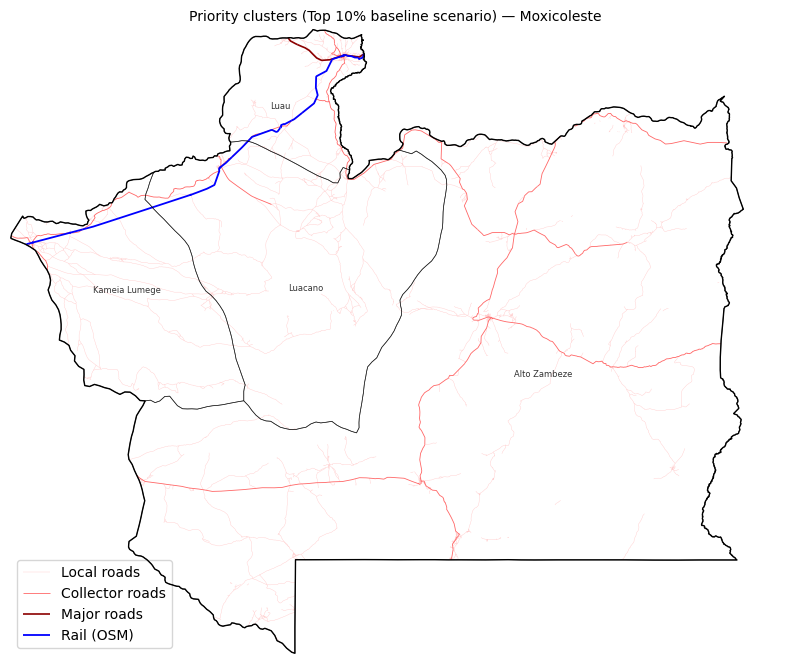

Saved Figure S1 map → /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/figs/moxicoleste_fig_s1_priority_clusters_adm2_roads.png


In [3]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show

from config import PATHS, PRIORITY_CLUSTERS_TIF

# Current AOI is set via AOI_VALUE + os.environ["AOI"]
aoi = os.environ.get("AOI", "unknown")
print("Current AOI:", aoi)

cluster_raster = PRIORITY_CLUSTERS_TIF
if not cluster_raster.exists():
    raise FileNotFoundError(f"Cluster raster missing: {cluster_raster}")

# -------------------------------------------------------------------
# Read cluster raster
# -------------------------------------------------------------------
with rasterio.open(cluster_raster) as src:
    arr = src.read(1)
    transform = src.transform
    crs = src.crs

    # Treat zeros & NaNs as background
    arr = np.where(np.isfinite(arr) & (arr > 0), arr, np.nan)

# -------------------------------------------------------------------
# Read vector layers: ADM1, ADM2, rail, roads
# -------------------------------------------------------------------
adm1 = gpd.read_file(PATHS.BND_ADM1).to_crs(crs)
adm2 = gpd.read_file(PATHS.BND_ADM2).to_crs(crs)
rail = gpd.read_file(PATHS.RAIL).to_crs(crs)
roads = gpd.read_file(PATHS.ROADS).to_crs(crs)

# -------------------------------------------------------------------
# Classify roads into Major / Collector / Local by fclass
# -------------------------------------------------------------------
if "fclass" in roads.columns:
    f = roads["fclass"].str.lower().fillna("")

    major_classes = {
        "motorway", "motorway_link",
        "trunk", "trunk_link",
        "primary", "primary_link",
    }
    collector_classes = {
        "secondary", "secondary_link",
        "tertiary", "tertiary_link",
    }

    def classify_road(val: str) -> str:
        if val in major_classes:
            return "major"
        if val in collector_classes:
            return "collector"
        return "local"

    roads["road_class"] = f.apply(classify_road)

    roads_major = roads[roads["road_class"] == "major"]
    roads_collector = roads[roads["road_class"] == "collector"]
    roads_local = roads[roads["road_class"] == "local"]
else:
    print("[WARN] 'fclass' column missing in roads; plotting all as 'local'.")
    roads["road_class"] = "local"
    roads_major = roads.iloc[0:0].copy()
    roads_collector = roads.iloc[0:0].copy()
    roads_local = roads

# -------------------------------------------------------------------
# Prepare Admin2 label points (use representative_point to stay inside polygons)
# -------------------------------------------------------------------
if "NAM_2" in adm2.columns:
    adm2["label_point"] = adm2.geometry.representative_point()
else:
    print("[WARN] 'NAM_2' column missing in ADM2; no labels will be drawn.")

# -------------------------------------------------------------------
# Plot
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 8))

# Priority clusters raster (background)
show(
    arr,
    transform=transform,
    ax=ax,
    cmap="OrRd",
    interpolation="nearest",
    zorder=1,
)

# Roads (drawn below boundaries; major on top of other roads)
if not roads_local.empty:
    roads_local.plot(
        ax=ax, linewidth=0.3, color="#ffcccc", label="Local roads", zorder=2
    )
if not roads_collector.empty:
    roads_collector.plot(
        ax=ax, linewidth=0.6, color="#ff6666", label="Collector roads", zorder=3
    )
if not roads_major.empty:
    roads_major.plot(
        ax=ax, linewidth=1.2, color="#8b0000", label="Major roads", zorder=4
    )

# Rail (distinct blue)
rail.plot(ax=ax, linewidth=1.3, color="blue", label="Rail (OSM)", zorder=5)

# Admin boundaries
adm2.boundary.plot(ax=ax, linewidth=0.5, color="black", alpha=0.7, zorder=6)
adm1.boundary.plot(ax=ax, linewidth=1.0, color="black", zorder=7)

# Admin2 labels
if "NAM_2" in adm2.columns:
    for _, row in adm2.iterrows():
        x, y = row["label_point"].x, row["label_point"].y
        name = str(row["NAM_2"])
        ax.text(
            x,
            y,
            name,
            fontsize=6,
            ha="center",
            va="center",
            color="black",
            alpha=0.8,
            zorder=8,
        )

ax.set_title(
    f"Priority clusters (Top 10% baseline scenario) — {aoi.capitalize()}",
    fontsize=10,
)
ax.set_axis_off()

# Clean legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="lower left")

fig.tight_layout()

# Show in notebook
plt.show()

# Save to file
out_fig_dir = PATHS.OUT_F
out_fig_dir.mkdir(parents=True, exist_ok=True)
out_png = out_fig_dir / f"{aoi}_fig_s1_priority_clusters_adm2_roads.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
print("Saved Figure S1 map →", out_png)


## Table S2 – Top municipalities by composite score (corridor-wide)

In [4]:
from pathlib import Path
import os
import numpy as np
import pandas as pd

from config import PATHS

OUT_T = PATHS.OUT_T

AOI = os.environ.get("AOI", "").strip()
if not AOI:
    raise SystemExit("AOI env var not set; run the bootstrap cell first.")
print("Tables dir:", OUT_T.resolve())
print("AOI       :", AOI)

TOP_N = 5  # how many top municipalities to include

# Rank table (canonical Step 07 output)
rank_path = OUT_T / f"{AOI}_priority_admin2_rank.csv"
if not rank_path.exists():
    # Fallback for legacy runs if needed
    rank_path = OUT_T / f"{AOI}_priority_muni_rank.csv"

if not rank_path.exists():
    raise SystemExit(f"No rank file found for AOI={AOI}: {rank_path.name}")

# Indicators table (Step 06 outputs)
ind_path = OUT_T / f"{AOI}_municipality_indicators.csv"
if not ind_path.exists():
    raise SystemExit(f"Missing indicators file: {ind_path.name}")

rank = pd.read_csv(rank_path)
ind = pd.read_csv(ind_path)

print(f"\n=== AOI: {AOI} | rank_rows={len(rank)} indicators_rows={len(ind)} ===")

# Sanity: ADM2 key must exist
for col in ["ADM2CD_c", "NAM_1", "NAM_2"]:
    if col not in rank.columns:
        raise ValueError(f"{rank_path.name} missing required column {col!r}")
    if col not in ind.columns:
        raise ValueError(f"{ind_path.name} missing required column {col!r}")

# Priority score / area come from the rank table
required_rank_cols = ["score", "total_km2", "share_selected"]
for col in required_rank_cols:
    if col not in rank.columns:
        raise ValueError(f"{rank_path.name} missing required column {col!r}")

# Map indicators → friendly names
col_poverty = "poverty__poverty_rural"
col_food    = "foodinsecurity__food_insec_scale"
col_tt      = "traveltime__avg_minutes_to_market_financial"
col_elec    = "infra__electricity"

for col, label in [
    (col_poverty, "poverty_rural"),
    (col_food,    "food_insec_scale"),
    (col_tt,      "mean_travel_time_min"),
    (col_elec,    "pct_electrified"),
]:
    if col not in ind.columns:
        raise ValueError(
            f"{ind_path.name} missing expected indicator column {col!r} "
            f"(needed for {label})"
        )

# Subset indicators to the fields we need + key
ind_sub = ind[[
    "ADM2CD_c", "NAM_1", "NAM_2",
    col_poverty, col_food, col_tt, col_elec,
]].copy()

ind_sub = ind_sub.rename(columns={
    col_poverty: "poverty_rural",
    col_food:    "food_insec_scale",
    col_tt:      "mean_travel_time_min",
    col_elec:    "pct_electrified",
})

# Merge indicators onto rank table
merged = rank.merge(
    ind_sub,
    on=["ADM2CD_c", "NAM_1", "NAM_2"],
    how="left",
    validate="one_to_one",
)

# Priority area (km²) and share of province *priority area* (%)
merged["priority_area_km2"] = merged["total_km2"] * merged["share_selected"]
total_priority_area = merged["priority_area_km2"].sum()

if total_priority_area > 0:
    merged["share_province_priority_pct"] = (
        merged["priority_area_km2"] / total_priority_area * 100.0
    )
else:
    merged["share_province_priority_pct"] = np.nan

# Take top N by composite score
top = merged.sort_values("score", ascending=False).head(TOP_N).copy()

table_s2 = pd.DataFrame({
    "Province (AOI)": [AOI] * len(top),
    "Municipality (Admin2)": top["NAM_2"],
    "Composite score (0–1)": top["score"],
    "Rural poverty index": top["poverty_rural"],
    "Food insecurity index": top["food_insec_scale"],
    "Mean travel time (min)": top["mean_travel_time_min"],
    "% electrified": top["pct_electrified"] * 100.0,
    "Share of province priority area (%)": top["share_province_priority_pct"],
})

# Round for readability
round_cols = [
    "Composite score (0–1)",
    "Rural poverty index",
    "Food insecurity index",
    "Mean travel time (min)",
    "% electrified",
    "Share of province priority area (%)",
]
for c in round_cols:
    if c in table_s2.columns:
        table_s2[c] = table_s2[c].round(3)

out_csv = OUT_T / f"{AOI}_summary_table_s2_top_municipalities.csv"
table_s2.to_csv(out_csv, index=False)
print("\nSaved Table S2 CSV →", out_csv)

table_s2


Tables dir: /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables
AOI       : moxicoleste

=== AOI: moxicoleste | rank_rows=1 indicators_rows=4 ===

Saved Table S2 CSV → /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables/moxicoleste_summary_table_s2_top_municipalities.csv


,Province (AOI),Municipality (Admin2),Composite score (0–1),Rural poverty index,Food insecurity index,Mean travel time (min),% electrified,Share of province priority area (%)
0,moxicoleste,Alto Zambeze,0.732,0.739,0.647,196.08,4.3,NaN


## Figure S2 – Priority score vs rural poverty (scatter, all municipalities)

Tables dir: /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables
AOI       : moxicoleste
Municipalities with score & rural poverty: 1


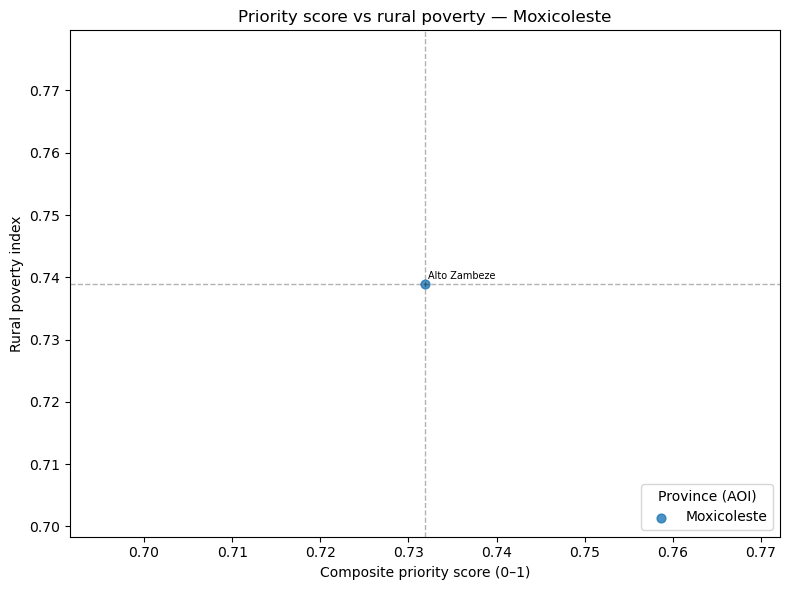

Saved Figure S2 → /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/figs/moxicoleste_fig_s2_priority_vs_poverty_scatter.png
Saved S2 base → /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables/moxicoleste_s2_base_score_poverty.csv
Saved S2 medians → /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables/moxicoleste_s2_base_score_poverty.meta.json
Figure medians: score=0.732, poverty_rural=0.739


In [5]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from config import PATHS

OUT_T = PATHS.OUT_T
OUT_F = PATHS.OUT_F

AOI = os.environ.get("AOI", "").strip()
if not AOI:
    raise SystemExit("AOI env var not set; run the bootstrap cell first.")
print("Tables dir:", OUT_T.resolve())
print("AOI       :", AOI)

# Rank table for this AOI
rank_path = OUT_T / f"{AOI}_priority_admin2_rank.csv"
if not rank_path.exists():
    rank_path = OUT_T / f"{AOI}_priority_muni_rank.csv"
if not rank_path.exists():
    raise SystemExit(f"No rank file found for AOI={AOI}: tried *_priority_admin2_rank.csv and *_priority_muni_rank.csv")

# Indicators (for poverty__poverty_rural)
ind_path = OUT_T / f"{AOI}_municipality_indicators.csv"
if not ind_path.exists():
    raise SystemExit(f"Missing indicators file for AOI={AOI}: {ind_path.name}")

rank = pd.read_csv(rank_path)
ind = pd.read_csv(ind_path)

col_poverty = "poverty__poverty_rural"
if col_poverty not in ind.columns:
    raise ValueError(f"{ind_path.name} missing expected column {col_poverty!r}")

# IMPORTANT: ensure poverty_rural comes from indicators (so all downstream agrees)
rank = rank.drop(columns=[c for c in ["poverty_rural", "poverty__poverty_rural"] if c in rank.columns], errors="ignore")

merged = rank.merge(
    ind[["ADM2CD_c", col_poverty]],
    on="ADM2CD_c",
    how="left",
    validate="one_to_one",
).rename(columns={col_poverty: "poverty_rural"})

# Keep only those with both score and rural poverty
mask = merged["score"].notna() & merged["poverty_rural"].notna()
data = merged.loc[mask].copy()
print("Municipalities with score & rural poverty:", len(data))

if data.empty:
    raise SystemExit("No municipalities with both score and poverty_rural.")

# Medians (these define quadrants AND are drawn on the plot)
x_med = float(pd.to_numeric(data["score"], errors="coerce").median())
y_med = float(pd.to_numeric(data["poverty_rural"], errors="coerce").median())

# -------------------------------------------------------------------
# Scatter: score vs rural poverty for this AOI
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(
    data["score"],
    data["poverty_rural"],
    s=40,
    alpha=0.8,
    label=AOI.capitalize(),
)

ax.set_xlabel("Composite priority score (0–1)")
ax.set_ylabel("Rural poverty index")
ax.set_title(f"Priority score vs rural poverty — {AOI.capitalize()}")

ax.axvline(x_med, color="k", linestyle="--", linewidth=1, alpha=0.3)
ax.axhline(y_med, color="k", linestyle="--", linewidth=1, alpha=0.3)

# label each point
for _, row in data.iterrows():
    name = str(row.get("NAM_2", row.get("ADM2CD_c")))
    ax.annotate(
        name,
        xy=(row["score"], row["poverty_rural"]),
        xytext=(2, 2),
        textcoords="offset points",
        fontsize=7,
        ha="left",
        va="bottom",
    )

ax.legend(title="Province (AOI)", loc="lower right")
fig.tight_layout()

out_fig = OUT_F / f"{AOI}_fig_s2_priority_vs_poverty_scatter.png"
fig.savefig(out_fig, dpi=300, bbox_inches="tight")
plt.show()
print("Saved Figure S2 →", out_fig)

# -------------------------------------------------------------------
# Write a shared "base" file so the next cells use EXACT same data
# -------------------------------------------------------------------
base_cols = [c for c in ["ADM2CD_c", "NAM_1", "NAM_2", "score", "poverty_rural"] if c in data.columns]
s2_base = data[base_cols].copy()

base_csv = OUT_T / f"{AOI}_s2_base_score_poverty.csv"
s2_base.to_csv(base_csv, index=False)

meta = {"aoi": AOI, "score_median": x_med, "poverty_median": y_med}
meta_json = OUT_T / f"{AOI}_s2_base_score_poverty.meta.json"
with open(meta_json, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("Saved S2 base →", base_csv)
print("Saved S2 medians →", meta_json)
print(f"Figure medians: score={x_med:.3f}, poverty_rural={y_med:.3f}")


### Quadrant stats

In [6]:
import os
import json
import numpy as np
import pandas as pd
from config import PATHS

OUT_T = PATHS.OUT_T
aoi = os.environ.get("AOI", "huambo").strip()
print("AOI:", aoi)

base_csv = OUT_T / f"{aoi}_s2_base_score_poverty.csv"
meta_json = OUT_T / f"{aoi}_s2_base_score_poverty.meta.json"

if not base_csv.exists():
    raise SystemExit(f"Missing {base_csv.name}. Run the Figure S2 cell first (it creates this base file).")

data = pd.read_csv(base_csv)
needed = {"ADM2CD_c", "score", "poverty_rural"}
missing = needed - set(data.columns)
if missing:
    raise SystemExit(f"{base_csv.name} missing required columns: {sorted(missing)}")

# Load the exact medians used by Figure S2 (so quadrants match the plot)
if meta_json.exists():
    meta = json.loads(meta_json.read_text(encoding="utf-8"))
    x_med = float(meta["score_median"])
    y_med = float(meta["poverty_median"])
else:
    x_med = float(pd.to_numeric(data["score"], errors="coerce").median())
    y_med = float(pd.to_numeric(data["poverty_rural"], errors="coerce").median())

print(f"Medians used for quadrants: score={x_med:.3f}, poverty_rural={y_med:.3f}")

# -------------------------------------------------------------------
# Quadrants using the SAME medians as the plot
# -------------------------------------------------------------------
def quadrant_label(row) -> str:
    hi_score = row["score"] >= x_med
    hi_pov = row["poverty_rural"] >= y_med
    if hi_score and hi_pov:
        return "High score & high poverty"
    if hi_score and not hi_pov:
        return "High score & lower poverty"
    if not hi_score and hi_pov:
        return "Lower score & high poverty"
    return "Lower score & lower poverty"

data["quadrant"] = data.apply(quadrant_label, axis=1)

# -------------------------------------------------------------------
# Optional: rural_poor_est if rural_pop_est exists in the rank file.
# If it's not available, still produce a stable table based on counts.
# -------------------------------------------------------------------
# Try to pull rural_pop_est by reloading the muni_rank if present (optional)
rank_path = OUT_T / f"{aoi}_priority_muni_rank.csv"
if rank_path.exists():
    rank = pd.read_csv(rank_path)
    if {"ADM2CD_c", "rural_pop_est"}.issubset(rank.columns):
        data = data.merge(rank[["ADM2CD_c", "rural_pop_est"]], on="ADM2CD_c", how="left", validate="one_to_one")

def _poverty_rate(series: pd.Series) -> pd.Series:
    mx = float(series.max())
    s = pd.to_numeric(series, errors="coerce")
    if mx <= 1.5:
        return s.clip(0, 1)
    if mx <= 100.0:
        return (s / 100.0).clip(0, 1)
    return pd.Series(np.nan, index=s.index)

if "rural_pop_est" in data.columns and data["rural_pop_est"].notna().any():
    pov_rate = _poverty_rate(data["poverty_rural"])
    data["rural_poor_est"] = pd.to_numeric(data["rural_pop_est"], errors="coerce") * pov_rate

    quad_stats = (
        data.groupby("quadrant")
            .agg(
                n_munis=("ADM2CD_c", "count"),
                rural_poor_est=("rural_poor_est", "sum"),
            )
            .reset_index()
    )
    total_rural_poor = float(np.nansum(quad_stats["rural_poor_est"].values))
    quad_stats["share_aoi_rural_poor_pct"] = np.where(
        total_rural_poor > 0,
        quad_stats["rural_poor_est"] / total_rural_poor * 100.0,
        np.nan,
    )
else:
    quad_stats = (
        data.groupby("quadrant")
            .agg(n_munis=("ADM2CD_c", "count"))
            .reset_index()
    )
    quad_stats["rural_poor_est"] = np.nan
    quad_stats["share_aoi_rural_poor_pct"] = np.nan

# Sort order
order = [
    "High score & high poverty",
    "High score & lower poverty",
    "Lower score & high poverty",
    "Lower score & lower poverty",
]
quad_stats["order"] = quad_stats["quadrant"].apply(lambda q: order.index(q) if q in order else len(order))
quad_stats = quad_stats.sort_values("order").drop(columns="order")

# Round for readability
quad_stats["rural_poor_est"] = quad_stats["rural_poor_est"].round(0)
quad_stats["share_aoi_rural_poor_pct"] = quad_stats["share_aoi_rural_poor_pct"].round(0)

quad_stats_for_report = quad_stats.rename(columns={
    "quadrant": "Quadrant (score x poverty)",
    "n_munis": "Number of municipalities",
    "rural_poor_est": "Estimated rural poor (people)",
    "share_aoi_rural_poor_pct": "Share of province’s rural poor (%)",
})

display(quad_stats_for_report)

out_csv = OUT_T / f"{aoi}_summary_table_s2_quadrant_stats.csv"
quad_stats_for_report.to_csv(out_csv, index=False)
print("Saved quadrant stats →", out_csv)


AOI: moxicoleste
Medians used for quadrants: score=0.732, poverty_rural=0.739


,Quadrant (score x poverty),Number of municipalities,Estimated rural poor (people),Share of province’s rural poor (%)
0,High score & high poverty,1,620.0,100.0


Saved quadrant stats → /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables/moxicoleste_summary_table_s2_quadrant_stats.csv


### bullet summary

In [7]:
import os
import pandas as pd
from config import PATHS

OUT_T = PATHS.OUT_T
aoi = os.environ.get("AOI", "huambo").strip()

base_csv = OUT_T / f"{aoi}_s2_base_score_poverty.csv"
quad_csv = OUT_T / f"{aoi}_summary_table_s2_quadrant_stats.csv"

if not base_csv.exists():
    raise SystemExit(f"Missing {base_csv.name}. Run the Figure S2 cell first.")
if not quad_csv.exists():
    raise SystemExit(f"Missing {quad_csv.name}. Run the Quadrant table cell first.")

data = pd.read_csv(base_csv)
quad = pd.read_csv(quad_csv)

total_munis = len(data)

def _row_for(label: str):
    r = quad.loc[quad["Quadrant (score x poverty)"] == label]
    return None if r.empty else r.iloc[0]

hi_hi = _row_for("High score & high poverty")
lo_hi = _row_for("Lower score & high poverty")

lines = []

if hi_hi is not None:
    n_hi_hi = int(hi_hi["Number of municipalities"])
    pct_hi_hi = (n_hi_hi / total_munis * 100.0) if total_munis else 0.0
    share = hi_hi.get("Share of province’s rural poor (%)", None)
    if pd.notna(share):
        lines.append(
            f"- About {n_hi_hi} of {total_munis} municipalities ({pct_hi_hi:.1f}%) fall in the "
            f"**high score & high poverty** quadrant, representing roughly {float(share):.0f}% of the "
            f"estimated rural poor in {aoi.capitalize()} covered by the dataset."
        )
    else:
        lines.append(
            f"- About {n_hi_hi} of {total_munis} municipalities ({pct_hi_hi:.1f}%) fall in the "
            f"**high score & high poverty** quadrant."
        )

if lo_hi is not None:
    n_lo_hi = int(lo_hi["Number of municipalities"])
    pct_lo_hi = (n_lo_hi / total_munis * 100.0) if total_munis else 0.0
    share = lo_hi.get("Share of province’s rural poor (%)", None)
    if pd.notna(share):
        lines.append(
            f"- Around {n_lo_hi} municipalities ({pct_lo_hi:.1f}%) sit in the "
            f"**lower score & high poverty** quadrant, accounting for about {float(share):.0f}% of the "
            f"estimated rural poor — these are potentially under-prioritized areas."
        )
    else:
        lines.append(
            f"- Around {n_lo_hi} municipalities ({pct_lo_hi:.1f}%) sit in the "
            f"**lower score & high poverty** quadrant — potentially under-prioritized areas."
        )

print("\nSuggested markdown bullet points for the Summary page:\n")
print("```markdown")
for line in lines:
    print(line)
print("```")



Suggested markdown bullet points for the Summary page:

```markdown
- About 1 of 1 municipalities (100.0%) fall in the **high score & high poverty** quadrant, representing roughly 100% of the estimated rural poor in Moxicoleste covered by the dataset.
```


## Table S3 (top sites by 60-minute catchment)

In [8]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rioxarray as rxr
from pathlib import Path

from config import PATHS, AOI, CATCHMENTS_KPI_CSV  # <-- note CATCHMENTS_KPI_CSV from config


def build_table_s3(top_n: int = 10, thresh_min: int = 60) -> pd.DataFrame:
    """
    Build Table S3 for the current AOI:

    - Uses Step 12 KPI summary: {AOI}_catchments_kpis.csv
    - Filters to a single threshold (default: 60 minutes)
    - Ranks sites by population within that threshold
    - Joins optional site metadata from PATHS.SITES
    - Computes each site's share of the provincial population
      (based on PATHS.POP, the 1-km population raster).

    Returns
    -------
    DataFrame with columns ready to drop into Table S3.
    """
    csv_path = CATCHMENTS_KPI_CSV  # from config, not PATHS
    if not Path(csv_path).exists():
        raise FileNotFoundError(f"Catchment KPI table not found: {csv_path}")

    df = pd.read_csv(csv_path)
    if "thresh_min" not in df.columns or "pop" not in df.columns:
        raise ValueError(f"{csv_path} is missing 'thresh_min' or 'pop' columns")

    df = df[df["thresh_min"] == thresh_min].copy()
    if df.empty:
        raise ValueError(f"No records in {csv_path} for thresh_min={thresh_min}")

    # Rank sites by population at this threshold
    df = df.sort_values("pop", ascending=False).reset_index(drop=True)
    df["rank_pop_60min"] = np.arange(1, len(df) + 1)

    # Optional: join site metadata from the AOI sites shapefile
    site_name_col = None
    site_type_col = None

    try:
        sites = gpd.read_file(PATHS.SITES).reset_index().rename(columns={"index": "site_index"})
        # Align with Step 12 convention (site_index = 1..N)
        sites["site_index"] = sites["site_index"] + 1

        # Heuristic: choose best-guess name and type columns if they exist
        for cand in ["name", "NAME", "site_name", "Site", "SITE"]:
            if cand in sites.columns:
                site_name_col = cand
                break
        for cand in ["site_type", "SiteType", "TYPE", "type", "category", "Category"]:
            if cand in sites.columns:
                site_type_col = cand
                break

        meta_cols = ["site_index"]
        if site_name_col:
            meta_cols.append(site_name_col)
        if site_type_col:
            meta_cols.append(site_type_col)

        sites_meta = sites[meta_cols].copy()
        df = df.merge(sites_meta, on="site_index", how="left")
    except Exception as e:
        print(f"[WARN] Could not join site metadata from {PATHS.SITES}: {e}")
        df["site_name"] = np.nan
        df["site_type"] = np.nan
        site_name_col = "site_name"
        site_type_col = "site_type"

    # Provincial population denominator (from 1-km pop raster)
    pop_da = rxr.open_rasterio(PATHS.POP, masked=True).squeeze()
    total_pop = float(pop_da.sum().item())

    # Site ID: prefer human-readable name if available, else "site_<index>"
    if site_name_col and site_name_col in df.columns:
        df["Site ID"] = df[site_name_col].fillna(df["site_index"].map(lambda i: f"site_{int(i)}"))
    else:
        df["Site ID"] = df["site_index"].map(lambda i: f"site_{int(i)}")

    if site_type_col and site_type_col in df.columns:
        df["Site type"] = df[site_type_col]
    else:
        df["Site type"] = "unknown"

    # Per-site share of provincial population at this threshold
    df["pct_prov_pop_60min"] = (df["pop"] / total_pop) * 100.0

    if "cropland_km2" in df.columns:
        cropland_60 = df["cropland_km2"].round(2)
    else:
        cropland_60 = np.nan

    out = pd.DataFrame({
        "Province (AOI)": AOI.capitalize(),
        "Site ID": df["Site ID"],
        "Site type": df["Site type"],
        "Population within 60 min": df["pop"].round(0).astype("Int64"),
        "Cropland (km²) within 60 min": cropland_60,
        "% of provincial population within 60 min of this site": df["pct_prov_pop_60min"].round(2),
    })

    # Keep only the top_n rows for the summary table
    out = out.head(top_n).reset_index(drop=True)

    # --- SAVE TABLE S3 HERE ---
    out_path = PATHS.OUT_T / f"{AOI}_summary_table_s3_top_sites_{thresh_min}min.csv"
    out.to_csv(out_path, index=False)
    print(f"Saved Table S3 for {AOI} → {out_path}")

    return out

table_s3_huambo = build_table_s3(top_n=10, thresh_min=60)
table_s3_huambo


FileNotFoundError: Catchment KPI table not found: /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables/moxicoleste_catchments_kpis.csv

## Figure S3 (30/60/120-minute catchments + clusters + roads)

In [9]:
# Figure S3 — Catchment unions (30/60/120 min) and priority clusters
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
from pathlib import Path

from config import (
    PATHS,
    AOI,
    out_r,
    CATCHMENTS_KPI_CSV,
    PRIORITY_CLUSTERS_TIF,
)


def make_figure_s3(
    top_k_sites: int = 3,
    thresholds: tuple[int, ...] = (30, 60, 120),
    outfile: Path | None = None,
):
    """
    Build Figure S3 for the current AOI:

    - Selects top_k_sites by population within 60 min (from catchments_kpis.csv)
    - For each threshold in `thresholds`, builds the UNION of those sites'
      catchments from {AOI}_catch_site{N}_{thresh}min.tif
    - Plots:
        * priority clusters (Step 11 raster),
        * union catchment outlines at each threshold,
        * ADM2 boundaries + labels,
        * roads classified as Major / Collector / Local.
    """
    # ------------------------------------------------------------------
    # 1) Read catchment KPIs and pick top sites by 60-min population
    # ------------------------------------------------------------------
    csv_path = CATCHMENTS_KPI_CSV
    if not Path(csv_path).exists():
        raise FileNotFoundError(f"Catchment KPI table not found: {csv_path}")

    kpis = pd.read_csv(csv_path)
    required = {"thresh_min", "pop", "site_index"}
    if not required.issubset(kpis.columns):
        raise ValueError(f"{csv_path} missing required columns {required}")

    k60 = kpis[kpis["thresh_min"] == 60].copy()
    if k60.empty:
        raise ValueError(f"No rows for thresh_min=60 in {csv_path}")

    k60 = k60.sort_values("pop", ascending=False).reset_index(drop=True)
    top_sites = list(k60["site_index"].head(top_k_sites).astype(int))
    print(f"AOI={AOI} | Using top {len(top_sites)} sites by 60-min population: {top_sites}")

    # ------------------------------------------------------------------
    # 2) Priority clusters background (Step 11 raster)
    # ------------------------------------------------------------------
    if not Path(PRIORITY_CLUSTERS_TIF).exists():
        raise FileNotFoundError(f"Priority clusters raster not found: {PRIORITY_CLUSTERS_TIF}")
    clusters = rxr.open_rasterio(PRIORITY_CLUSTERS_TIF, masked=True).squeeze()
    clusters_crs = clusters.rio.crs
    
    template_da = None
    union_masks: dict[int, np.ndarray] = {}

    # ------------------------------------------------------------------
    # 3) Build union catchment masks for each threshold
    # ------------------------------------------------------------------
    for t in thresholds:
        union = None
        for sid in top_sites:
            tif = out_r(f"catch_site{int(sid)}_{t}min")
            if not Path(tif).exists():
                continue
            da = rxr.open_rasterio(tif, masked=True).squeeze()
            if template_da is None:
                template_da = da
            mask = (da.values > 0)
            union = mask if union is None else (union | mask)

        if union is not None:
            union_masks[t] = union

    if not union_masks:
        raise RuntimeError(
            "No union catchment masks could be built. "
            "Check that catch_site*_Xmin.tif exists in outputs/rasters."
        )

    # ------------------------------------------------------------------
    # 4) Base vectors: ADM2 + roads (classified), reprojected to raster CRS
    # ------------------------------------------------------------------
    adm2 = gpd.read_file(PATHS.BND_ADM2).to_crs(clusters_crs)
    roads = gpd.read_file(PATHS.ROADS).to_crs(clusters_crs)

    major_classes = {
        "motorway", "motorway_link",
        "trunk", "trunk_link",
        "primary", "primary_link",
    }
    collector_classes = {
        "secondary", "secondary_link",
        "tertiary", "tertiary_link",
    }

    def classify_road(row):
        fc = str(row.get("fclass", "")).lower()
        if fc in major_classes:
            return "Major"
        elif fc in collector_classes:
            return "Collector"
        else:
            # Local roads = everything else
            return "Local"

    roads["road_class"] = roads.apply(classify_road, axis=1)
    roads_major = roads[roads["road_class"] == "Major"]
    roads_collector = roads[roads["road_class"] == "Collector"]
    roads_local = roads[roads["road_class"] == "Local"]

    # ------------------------------------------------------------------
    # 5) Plot
    # ------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 8))

    # Background: priority clusters
    clusters.plot(
        ax=ax,
        cmap="YlOrRd",
        alpha=0.35,
        add_colorbar=False,
    )

    # Roads
    roads_local.plot(ax=ax, linewidth=0.4, alpha=0.3, color="lightgrey")
    roads_collector.plot(ax=ax, linewidth=0.7, alpha=0.6, color="grey")
    roads_major.plot(ax=ax, linewidth=1.2, alpha=0.9, color="darkred")

    # ADM2 boundaries + labels
    adm2.boundary.plot(ax=ax, linewidth=0.8, color="black")
    if "NAM_2" in adm2.columns:
        for _, row in adm2.iterrows():
            if row.geometry is None or row.geometry.is_empty:
                continue
            x, y = row.geometry.representative_point().x, row.geometry.representative_point().y
            ax.text(x, y, str(row["NAM_2"]), fontsize=7, ha="center", va="center")

    # Optional: plot top sites as points, if you have a sites layer with geometry
    try:
        sites_gdf = gpd.read_file(PATHS.SITES).to_crs(clusters_crs).reset_index()
        sites_gdf["site_index"] = sites_gdf["index"] + 1
        top_sites_gdf = sites_gdf[sites_gdf["site_index"].isin(top_sites)]
    
        top_sites_gdf.plot(ax=ax, markersize=20, color="black", zorder=6)
    
        for _, row in top_sites_gdf.iterrows():
            x, y = row.geometry.x, row.geometry.y
            label = f"S{int(row['site_index'])}"
            ax.text(x, y, label, fontsize=7, ha="left", va="bottom", color="black")
    except Exception as e:
        print(f"[WARN] Could not plot top sites: {e}")
        
    # Catchment contours on top
    if template_da is None:
        template_da = clusters

    colors_by_t = {
        30: "tab:blue",
        60: "tab:green",
        120: "tab:purple",
    }

    for t in thresholds:
        mask = union_masks.get(t)
        if mask is None:
            continue

        # IMPORTANT: keep 0 outside, 1 inside → contour at 0.5
        mask_float = mask.astype("float32")  # 1 inside, 0 outside

        da_t = template_da.copy()
        da_t.values = mask_float

        da_t.plot.contour(
            ax=ax,
            levels=[0.5],
            colors=colors_by_t.get(t, "black"),
            linewidths=2.0,      # thicker so it stands out
            linestyles="solid",
            add_colorbar=False,
        )

    ax.set_title(f"Catchment unions (30/60/120 min) and priority clusters — {AOI.capitalize()}")
    ax.set_axis_off()



    # Legend
    from matplotlib.lines import Line2D
    threshold_lines = [
        Line2D([0], [0],
               color=colors_by_t.get(t, "black"),
               lw=2.0,
               label=f"{t}-min catchment")
        for t in thresholds if t in union_masks
    ]
    road_lines = [
        Line2D([0], [0], color="darkred", lw=1.2, label="Major roads"),
        Line2D([0], [0], color="grey", lw=0.7, label="Collector roads"),
        Line2D([0], [0], color="lightgrey", lw=0.4, label="Local roads"),
    ]
    handles = threshold_lines + road_lines
    ax.legend(handles=handles, loc="lower left", fontsize=7, frameon=True)

    fig.tight_layout()

    if outfile is None:
        outfile = PATHS.OUT_F / f"{AOI}_fig_s3_catchments_union.png"
    outfile = Path(outfile)
    outfile.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(outfile, dpi=300, bbox_inches="tight")
    print("Saved figure to:", outfile)

    plt.show()
    return fig, ax


# Run for current AOI (e.g. Huambo)
fig_s3, ax_s3 = make_figure_s3(top_k_sites=3, thresholds=(30, 60, 120))


FileNotFoundError: Catchment KPI table not found: /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables/moxicoleste_catchments_kpis.csv

## Table S4 – clusters with highest project density (x km)

In [10]:
import pandas as pd
from pathlib import Path

from config import AOI, PATHS, out_t  # use existing helper from config.py


def _available_radii(df: pd.DataFrame) -> list[int]:
    """
    Discover radii (in km) available in the cluster_synergies table.

    Looks for columns like 'count_gov_le5km', 'count_gov_le10km', etc.
    """
    radii = set()
    for c in df.columns:
        if c.startswith("count_gov_le") and "km" in c:
            try:
                r = int(c.split("le")[1].split("km")[0])
                radii.add(r)
            except ValueError:
                # ignore odd column names
                continue
    return sorted(radii)


def build_table_s4(top_n: int = 10, radius_km: int = 10) -> pd.DataFrame:
    """
    Build Table S4 for the current AOI.

    Uses Step 13 output:
      outputs/tables/{AOI}_cluster_synergies.csv

    Assumes columns of the form:
      - cluster_id, lon, lat
      - count_gov_le{r}km, count_wb_le{r}km, count_oth_le{r}km
        for one or more radii r (e.g. 5, 10, 30).

    Parameters
    ----------
    top_n : int
        Number of clusters to keep (sorted by total projects in the radius).
    radius_km : int
        Desired radius in km. If this radius is not present in the CSV,
        the function will snap to the nearest available radius and print
        an info message.

    Returns
    -------
    pd.DataFrame
        Tidy table for S4 with AOI name, cluster ID and project counts
        within the chosen radius.
    """
    csv_path = Path(out_t("cluster_synergies"))
    if not csv_path.exists():
        raise FileNotFoundError(f"Cluster synergies table not found: {csv_path}")

    df = pd.read_csv(csv_path)

    # Discover which radii are actually present in the file
    radii = _available_radii(df)
    if not radii:
        raise ValueError(
            f"{csv_path} has no 'count_gov_le*km' columns; "
            "did Step 13 run successfully?"
        )

    # If requested radius is not present, snap to the nearest one
    if radius_km not in radii:
        snapped = min(radii, key=lambda r: abs(r - radius_km))
        print(
            f"[INFO] Requested radius_km={radius_km} km not found in "
            f"{csv_path.name}; using nearest available radius {snapped} km."
        )
        radius_km = snapped

    # Column names for the selected radius
    col_gov = f"count_gov_le{radius_km}km"
    col_wb  = f"count_wb_le{radius_km}km"
    col_oth = f"count_oth_le{radius_km}km"

    needed = ["cluster_id", col_gov, col_wb, col_oth]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(
            f"{csv_path} is missing expected columns {missing}. "
            f"Available columns: {list(df.columns)}"
        )

    # Clean numeric counts
    for c in (col_gov, col_wb, col_oth):
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype("int64")

    # Total projects within the chosen radius
    total_col = f"total_proj_le{radius_km}km"
    df[total_col] = df[col_gov] + df[col_wb] + df[col_oth]

    # Quick debug summary (helps explain "all zeros" cases)
    non_zero = (df[total_col] > 0).sum()
    print(
        f"[INFO] Using radius {radius_km} km. "
        f"Clusters with ≥1 project in this radius: {non_zero} / {len(df)}."
    )

    # Sort by total projects (desc) and keep top N
    df_top = (
        df.sort_values(total_col, ascending=False)
          .head(top_n)
          .copy()
          .reset_index(drop=True)
    )

    # Human-friendly column labels
    radius_label = f"{radius_km} km"

    out = pd.DataFrame()
    out["Province (AOI)"] = [AOI.capitalize()] * len(df_top)
    out["Cluster ID"] = df_top["cluster_id"].astype(int).astype(str)
    out["Government projects " + radius_label] = df_top[col_gov].astype(int)
    out["World Bank projects " + radius_label] = df_top[col_wb].astype(int)
    out["Other partner projects " + radius_label] = df_top[col_oth].astype(int)
    out["Total projects " + radius_label] = df_top[total_col].astype(int)

    # --- SAVE TABLE S4 HERE ---
    out_path = PATHS.OUT_T / f"{AOI}_summary_table_s4_cluster_synergies_{radius_km}km.csv"
    out.to_csv(out_path, index=False)
    print(f"Saved Table S4 for {AOI} → {out_path}")

    return out

# Example: rebuild Table S4 for the current AOI (e.g. Huambo)
table_s4 = build_table_s4(top_n=10, radius_km=30)
table_s4


[INFO] Using radius 30 km. Clusters with ≥1 project in this radius: 0 / 0.
Saved Table S4 for moxicoleste → /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables/moxicoleste_summary_table_s4_cluster_synergies_30km.csv


,Province (AOI),Cluster ID,Government projects 30 km,World Bank projects 30 km,Other partner projects 30 km,Total projects 30 km


## Figure S4 – project density around priority clusters

[INFO] gov projects not found: ago_poi_moxicoleste_projects_gov_p.shp
[INFO] wb projects not found: ago_poi_moxicoleste_projects_wb_p.shp
[INFO] oth projects not found: ago_poi_moxicoleste_projects_others_p.shp
Clusters: 0
Projects: 0
Saved figure to: /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/figs/moxicoleste_fig_s4_cluster_synergies_30km.png


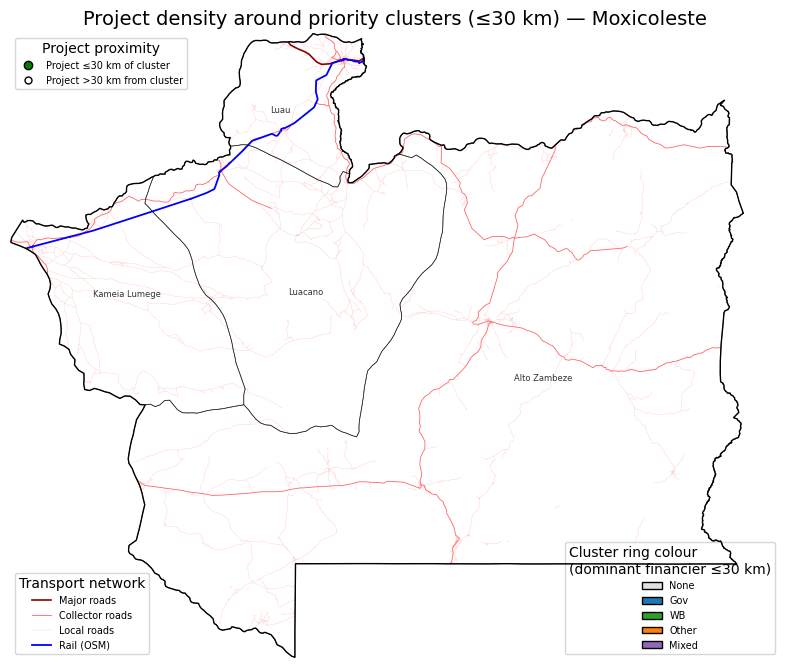

In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from pathlib import Path
import rasterio
from rasterio.plot import show
from pyproj import Geod

from config import (
    AOI,
    PATHS,
    out_t,
    PRIORITY_CLUSTERS_TIF,
    PROJECTS_GOV,
    PROJECTS_WB,
    PROJECTS_OTH,
)

_G = Geod(ellps="WGS84")


# ---------------------------------------------------------------------
# Small helpers
# ---------------------------------------------------------------------
def _as_points_rep(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Ensure layer is point-type (lines/polys -> representative_point)."""
    if gdf.empty:
        return gdf
    if gdf.crs is None:
        gdf = gdf.set_crs("EPSG:4326")
    else:
        gdf = gdf.to_crs("EPSG:4326")

    def _rep(geom):
        if geom is None or geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        return geom.representative_point()

    out = gdf.copy()
    out["geometry"] = out.geometry.apply(_rep)
    out = out[~out.geometry.isna()].copy()
    return out


def _load_projects(fp: Path | None, tag: str) -> gpd.GeoDataFrame:
    """Load projects layer from config, convert to points, tag with source."""
    cols = ["source", "geometry"]
    if fp is None:
        return gpd.GeoDataFrame(columns=cols, geometry="geometry", crs="EPSG:4326")
    p = Path(fp)
    if not p.exists():
        print(f"[INFO] {tag} projects not found: {p.name}")
        return gpd.GeoDataFrame(columns=cols, geometry="geometry", crs="EPSG:4326")
    g = gpd.read_file(p)
    g = _as_points_rep(g)
    g["source"] = tag
    return g[cols]


def _nearest_distance_to_clusters_km(p_lon, p_lat, c_lon, c_lat):
    """
    For each project, compute distance (km) to nearest cluster centroid.
    Uses explicit reshape to avoid pyproj broadcasting issues.
    """
    n_p = len(p_lon)
    n_c = len(c_lon)
    if n_p == 0 or n_c == 0:
        return np.full(n_p, np.nan, dtype="float32")

    lon1 = np.repeat(p_lon, n_c)
    lat1 = np.repeat(p_lat, n_c)
    lon2 = np.tile(c_lon, n_p)
    lat2 = np.tile(c_lat, n_p)

    _, _, dist_m = _G.inv(lon1, lat1, lon2, lat2)
    D = dist_m.reshape(n_p, n_c) / 1000.0  # km
    return D.min(axis=1).astype("float32")


def _dominant_financier(g, w, o) -> str:
    """Return 'none', 'gov', 'wb', 'oth', or 'mixed'."""
    vals = np.array([g, w, o], dtype=int)
    if vals.sum() == 0:
        return "none"
    mx = vals.max()
    who = [src for src, v in zip(("gov", "wb", "oth"), vals) if v == mx and v > 0]
    if len(who) == 1:
        return who[0]
    return "mixed"


# ---------------------------------------------------------------------
# Main plotting function
# ---------------------------------------------------------------------
def make_figure_s4(radius_km: int = 10,
                   min_total_projects: int = 0,
                   outfile: Path | None = None):
    """
    Figure S4 – Project density around priority clusters.

    - Background: priority clusters raster.
    - Roads & rail: same styling as S1.
    - Cluster centroids: rings sized by total projects within `radius_km`,
      coloured by dominant financier (Gov/WB/Other/Mixed/None).
    - Projects: points coloured by whether they are within `radius_km`
      of ANY cluster (green) or not (white).
    """

    # ----------------- 1. Cluster synergies & centroids -----------------
    sy_csv = Path(out_t("cluster_synergies"))
    if not sy_csv.exists():
        raise FileNotFoundError(f"Cluster synergies table not found: {sy_csv}")

    df = pd.read_csv(sy_csv)

    col_gov = f"count_gov_le{radius_km}km"
    col_wb  = f"count_wb_le{radius_km}km"
    col_oth = f"count_oth_le{radius_km}km"
    needed = {"cluster_id", "lon", "lat", col_gov, col_wb, col_oth}
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"{sy_csv} missing columns {missing}")

    for c in (col_gov, col_wb, col_oth):
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype("int64")

    df["total_projects"] = df[col_gov] + df[col_wb] + df[col_oth]
    df["dominant"] = [
        _dominant_financier(g, w, o)
        for g, w, o in zip(df[col_gov], df[col_wb], df[col_oth])
    ]

    if min_total_projects > 0:
        df = df[df["total_projects"] >= min_total_projects].copy()

    df = df.dropna(subset=["lon", "lat"]).copy()

    g_clusters_4326 = gpd.GeoDataFrame(
        df.copy(),
        geometry=gpd.points_from_xy(df["lon"], df["lat"]),
        crs="EPSG:4326",
    )

    # ----------------- 2. Projects from config -----------------
    g_gov = _load_projects(PROJECTS_GOV, "gov")
    g_wb  = _load_projects(PROJECTS_WB,  "wb")
    g_oth = _load_projects(PROJECTS_OTH, "oth")

    projects_4326 = pd.concat([g_gov, g_wb, g_oth], ignore_index=True)
    projects_4326 = gpd.GeoDataFrame(projects_4326, geometry="geometry", crs="EPSG:4326")

    # Distances project→cluster
    if not projects_4326.empty and not g_clusters_4326.empty:
        p_lon = projects_4326.geometry.x.values
        p_lat = projects_4326.geometry.y.values
        c_lon = g_clusters_4326.geometry.x.values
        c_lat = g_clusters_4326.geometry.y.values

        nearest = _nearest_distance_to_clusters_km(p_lon, p_lat, c_lon, c_lat)
        projects_4326["dist_to_cluster_km"] = nearest
        projects_4326["within_radius"] = nearest <= float(radius_km)
    else:
        projects_4326["dist_to_cluster_km"] = np.nan
        projects_4326["within_radius"] = False

    # Simple debug stats (printed in notebook)
    print("Clusters:", len(g_clusters_4326))
    print("Projects:", len(projects_4326))
    if len(projects_4326):
        print(f"Projects within {radius_km} km of any cluster:",
              int(projects_4326["within_radius"].sum()))
    if len(df):
        print("Cluster total_projects stats:\n", df["total_projects"].describe())

    # ----------------- 3. Raster & base vectors (S1 style) -----------------
    cluster_raster = PRIORITY_CLUSTERS_TIF
    if not cluster_raster.exists():
        raise FileNotFoundError(f"Cluster raster missing: {cluster_raster}")

    with rasterio.open(cluster_raster) as src:
        arr = src.read(1)
        transform = src.transform
        crs = src.crs
        arr = np.where(np.isfinite(arr) & (arr > 0), arr, np.nan)

    adm1 = gpd.read_file(PATHS.BND_ADM1).to_crs(crs)
    adm2 = gpd.read_file(PATHS.BND_ADM2).to_crs(crs)
    rail = gpd.read_file(PATHS.RAIL).to_crs(crs)
    roads = gpd.read_file(PATHS.ROADS).to_crs(crs)

    g_clusters = g_clusters_4326.to_crs(crs)
    projects = projects_4326.to_crs(crs)

    # Road classification like S1
    if "fclass" in roads.columns:
        f = roads["fclass"].str.lower().fillna("")

        major_classes = {
            "motorway", "motorway_link",
            "trunk", "trunk_link",
            "primary", "primary_link",
        }
        collector_classes = {
            "secondary", "secondary_link",
            "tertiary", "tertiary_link",
        }

        def classify_road(val: str) -> str:
            if val in major_classes:
                return "major"
            if val in collector_classes:
                return "collector"
            return "local"

        roads["road_class"] = f.apply(classify_road)
        roads_major = roads[roads["road_class"] == "major"]
        roads_collector = roads[roads["road_class"] == "collector"]
        roads_local = roads[roads["road_class"] == "local"]
    else:
        print("[WARN] 'fclass' column missing in roads; plotting all as 'local'.")
        roads["road_class"] = "local"
        roads_major = roads.iloc[0:0].copy()
        roads_collector = roads.iloc[0:0].copy()
        roads_local = roads

    # Admin2 labels
    if "NAM_2" in adm2.columns:
        adm2["label_point"] = adm2.geometry.representative_point()
    else:
        print("[WARN] 'NAM_2' column missing in ADM2; no labels will be drawn.")

    # ----------------- 4. Plot -----------------
    fig, ax = plt.subplots(figsize=(8, 10))

    # Priority clusters raster
    show(
        arr,
        transform=transform,
        ax=ax,
        cmap="OrRd",
        interpolation="nearest",
        zorder=1,
        alpha=0.45,
    )

    # Roads & rail (S1 style)
    if not roads_local.empty:
        roads_local.plot(ax=ax, linewidth=0.3, color="#ffcccc",
                         label="Local roads", zorder=2)
    if not roads_collector.empty:
        roads_collector.plot(ax=ax, linewidth=0.6, color="#ff6666",
                             label="Collector roads", zorder=3)
    if not roads_major.empty:
        roads_major.plot(ax=ax, linewidth=1.2, color="#8b0000",
                         label="Major roads", zorder=4)
    if not rail.empty:
        rail.plot(ax=ax, linewidth=1.3, color="blue",
                  label="Rail (OSM)", zorder=5)

    # Boundaries & labels
    adm2.boundary.plot(ax=ax, linewidth=0.5, color="black",
                       alpha=0.7, zorder=6)
    adm1.boundary.plot(ax=ax, linewidth=1.0, color="black", zorder=7)

    if "NAM_2" in adm2.columns:
        for _, row in adm2.iterrows():
            if row.geometry is None or row.geometry.is_empty:
                continue
            x, y = row["label_point"].x, row["label_point"].y
            ax.text(
                x, y, str(row["NAM_2"]),
                fontsize=6, ha="center", va="center",
                color="black", alpha=0.8, zorder=8,
            )

    # Cluster rings: size by total_projects, color by dominant financier
    dom_colors = {
        "none":  "#e0e0e0",
        "gov":   "#1f77b4",
        "wb":    "#2ca02c",
        "oth":   "#ff7f0e",
        "mixed": "#9467bd",
    }
    if not g_clusters.empty:
        base_size = 20.0
        scale = 10.0
        sizes = base_size + scale * g_clusters["total_projects"].clip(0, 20)
        facecolors = [dom_colors.get(d, "#e0e0e0") for d in g_clusters["dominant"]]

        ax.scatter(
            g_clusters.geometry.x,
            g_clusters.geometry.y,
            s=sizes,
            facecolors=facecolors,
            edgecolors="black",
            linewidths=0.7,
            alpha=0.9,
            zorder=9,
        )

    # Projects: white vs green depending on radius
    if not projects.empty:
        near = projects[projects["within_radius"]]
        far = projects[~projects["within_radius"]]

        if not far.empty:
            ax.scatter(
                far.geometry.x,
                far.geometry.y,
                s=18,
                facecolors="white",
                edgecolors="black",
                linewidths=0.5,
                alpha=0.8,
                zorder=10,
            )
        if not near.empty:
            ax.scatter(
                near.geometry.x,
                near.geometry.y,
                s=30,
                facecolors="green",
                edgecolors="black",
                linewidths=0.7,
                alpha=0.9,
                zorder=11,
            )

    ax.set_title(
        f"Project density around priority clusters (≤{radius_km} km) — {AOI.capitalize()}",
        fontsize=14,
    )
    ax.set_axis_off()

    # ----------------- 5. Legends -----------------
    # Transport legend
    road_handles = []
    if not roads_major.empty:
        road_handles.append(Line2D([0], [0], color="#8b0000", lw=1.2, label="Major roads"))
    if not roads_collector.empty:
        road_handles.append(Line2D([0], [0], color="#ff6666", lw=0.6, label="Collector roads"))
    if not roads_local.empty:
        road_handles.append(Line2D([0], [0], color="#ffcccc", lw=0.3, label="Local roads"))
    rail_handles = []
    if not rail.empty:
        rail_handles.append(Line2D([0], [0], color="blue", lw=1.3, label="Rail (OSM)"))

    leg1 = ax.legend(
        handles=road_handles + rail_handles,
        loc="lower left", fontsize=7, frameon=True, title="Transport network"
    )
    ax.add_artist(leg1)

    # Project proximity legend (green vs white)
    proj_handles = [
        Line2D([], [], marker="o", linestyle="", markerfacecolor="green",
               markeredgecolor="black", markersize=6,
               label=f"Project ≤{radius_km} km of cluster"),
        Line2D([], [], marker="o", linestyle="", markerfacecolor="white",
               markeredgecolor="black", markersize=5,
               label=f"Project >{radius_km} km from cluster"),
    ]
    leg2 = ax.legend(
        handles=proj_handles,
        loc="upper left", fontsize=7, frameon=True,
        title="Project proximity",
    )
    ax.add_artist(leg2)

    # Dominant financier legend for cluster colours
    dom_handles = [
        Patch(facecolor=dom_colors[k], edgecolor="black", label=lab)
        for k, lab in [
            ("none",  "None"),
            ("gov",   "Gov"),
            ("wb",    "WB"),
            ("oth",   "Other"),
            ("mixed", "Mixed"),
        ]
    ]
    ax.legend(
        handles=dom_handles,
        loc="lower right", fontsize=7, frameon=True,
        title=f"Cluster ring colour\n(dominant financier ≤{radius_km} km)",
    )

    fig.tight_layout()

    # ----------------- 6. Save -----------------
    if outfile is None:
        outfile = PATHS.OUT_F / f"{AOI}_fig_s4_cluster_synergies_{radius_km}km.png"
    outfile = Path(outfile)
    outfile.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(outfile, dpi=300, bbox_inches="tight")
    print("Saved figure to:", outfile)

    plt.show()
    return fig, ax


# Run for current AOI
fig_s4, ax_s4 = make_figure_s4(radius_km=30, min_total_projects=0)


### Enrich OD zone attributes with a priority flag

To make **Table S5 – High-throughput municipality pairs** more informative,  
we want to know whether both the **origin and destination** municipalities fall
inside the **top priority mask** from the 1-km priority surface (Step 07 / 09).

In practice:

- `{AOI}_priority_admin2_rank.csv` already tells us, for each municipality:
  - `share_selected` – share of its area inside the priority mask, and
  - `selected` – whether it was selected as a top-priority Admin2.
- `{AOI}_od_zone_attrs.csv` holds the OD “nodes” (one row per municipality),
  with `ADM2CD_c`, `NAM_2`, lon/lat, and other attributes.

In the cell below we **join these two tables** and add a boolean flag  
`in_priority_mask` to `{AOI}_od_zone_attrs.csv`, defined as:

> `in_priority_mask = True` if `share_selected > 0` (computed directly if present, otherwise derived from `selected_cells/total_cells` or `selected_km2/total_km2`; last resort uses `selected` as a proxy).


This lets the Table S5 builder label each OD pair with  
**“Both in top priority mask?” → Yes / No** instead of `N/A`.

> ⚙️ **When to run:**  
> Run this enrichment cell **once per AOI**, after the main pipeline has run
> at least up to **Step 09 (Admin2 ranking)** so that
> `{AOI}_priority_admin2_rank.csv` already exists.


In [12]:
from pathlib import Path
import numpy as np
import pandas as pd
from config import AOI, PATHS, out_t

# Paths
attrs_path = Path(out_t("od_zone_attrs"))  # e.g. outputs/tables/bie_od_zone_attrs.csv
rank_path  = PATHS.OUT_T / f"{AOI}_priority_admin2_rank.csv"

print("OD zone attrs:", attrs_path)
print("Priority rank:", rank_path)

if not attrs_path.exists():
    raise FileNotFoundError(f"OD zone attributes not found: {attrs_path}")
if not rank_path.exists():
    raise FileNotFoundError(f"Priority Admin2 rank table not found: {rank_path}")

attrs = pd.read_csv(attrs_path)
rank  = pd.read_csv(rank_path)

# --- sanity: keys ---
for df, name in [(attrs, attrs_path.name), (rank, rank_path.name)]:
    if "ADM2CD_c" not in df.columns:
        raise ValueError(f"{name} missing required column 'ADM2CD_c'")

# normalize key dtype for safer merges
attrs["ADM2CD_c"] = attrs["ADM2CD_c"].astype(str)
rank["ADM2CD_c"]  = rank["ADM2CD_c"].astype(str)

# IMPORTANT: avoid suffix chaos if this cell was run before
# (otherwise you get share_selected_x / share_selected_y and KeyError)
attrs = attrs.drop(columns=["share_selected", "selected", "in_priority_mask"], errors="ignore")

# --- derive share_selected robustly ---
share_col = None

if "share_selected" in rank.columns:
    share_col = "share_selected"
else:
    cand = [c for c in rank.columns if ("share" in c.lower() and "selected" in c.lower())]
    if cand:
        share_col = cand[0]
        print(f"[info] Using {share_col!r} as share_selected (matched by name).")
    elif {"selected_cells", "total_cells"}.issubset(rank.columns):
        sel = pd.to_numeric(rank["selected_cells"], errors="coerce").fillna(0.0)
        tot = pd.to_numeric(rank["total_cells"], errors="coerce").fillna(0.0)
        rank["share_selected"] = np.where(tot > 0, sel / tot, 0.0)
        share_col = "share_selected"
        print("[info] Derived share_selected = selected_cells / total_cells.")
    elif {"selected_km2", "total_km2"}.issubset(rank.columns):
        sel = pd.to_numeric(rank["selected_km2"], errors="coerce").fillna(0.0)
        tot = pd.to_numeric(rank["total_km2"], errors="coerce").fillna(0.0)
        rank["share_selected"] = np.where(tot > 0, sel / tot, 0.0)
        share_col = "share_selected"
        print("[info] Derived share_selected = selected_km2 / total_km2.")
    elif "selected" in rank.columns:
        rank["share_selected"] = pd.to_numeric(rank["selected"], errors="coerce").fillna(0.0).astype(float)
        share_col = "share_selected"
        print("[warn] No share_* available; using 'selected' as a proxy for share_selected (1 if selected else 0).")

if share_col is None:
    raise ValueError(
        "Cannot derive 'share_selected' from the rank file. "
        f"Available columns: {list(rank.columns)}"
    )

# ensure selected exists (nice-to-have)
if "selected" not in rank.columns:
    rank["selected"] = pd.to_numeric(rank[share_col], errors="coerce").fillna(0).astype(float) > 0

# keep only what we need from the rank table
rank_sub = rank[["ADM2CD_c", share_col, "selected"]].copy()
if share_col != "share_selected":
    rank_sub = rank_sub.rename(columns={share_col: "share_selected"})

# merge onto OD zone attrs (use suffixes just in case you have any overlaps)
merged = attrs.merge(rank_sub, on="ADM2CD_c", how="left", suffixes=("", "_rank"))

# if suffixes still happened for any reason, normalize them back
if "share_selected" not in merged.columns and "share_selected_rank" in merged.columns:
    merged["share_selected"] = merged["share_selected_rank"]
if "selected" not in merged.columns and "selected_rank" in merged.columns:
    merged["selected"] = merged["selected_rank"]

# Boolean priority flag: any overlap with the priority mask
merged["share_selected"] = pd.to_numeric(merged["share_selected"], errors="coerce").fillna(0.0)
merged["selected"] = merged["selected"].fillna(False).astype(bool)
merged["in_priority_mask"] = merged["share_selected"] > 0

preview_cols = [c for c in ["ADM2CD_c", "NAM_2", "share_selected", "selected", "in_priority_mask"] if c in merged.columns]
print("\nPreview of enriched OD zone attrs:")
print(merged[preview_cols].head())

# overwrite the original file
merged.to_csv(attrs_path, index=False)
print("\nUpdated OD zone attributes with 'in_priority_mask' column →", attrs_path)


OD zone attrs: /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables/moxicoleste_od_zone_attrs.csv
Priority rank: /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables/moxicoleste_priority_admin2_rank.csv

Preview of enriched OD zone attrs:
    ADM2CD_c          NAM_2  share_selected  selected  in_priority_mask
0  AGO019001   Alto Zambeze             0.0     False             False
1  AGO019003  Kameia Lumege             0.0     False             False
2  AGO019005        Luacano             0.0     False             False
3  AGO019006           Luau             0.0     False             False

Updated OD zone attributes with 'in_priority_mask' column → /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables/moxicoleste_od_zone_attrs.csv


/tmp/ipykernel_13999/4088349782.py:87: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["selected"] = merged["selected"].fillna(False).astype(bool)


## Table S5 – High-throughput municipality pairs

In [13]:
import pandas as pd
from pathlib import Path

from config import AOI, PATHS, out_t  # <-- added PATHS


def build_table_s5(top_n: int = 10) -> pd.DataFrame:
    """
    Build Table S5 for the current AOI from Step 14 outputs:

      - {AOI}_od_gravity.csv     (out_t("od_gravity"))
      - {AOI}_od_zone_attrs.csv  (out_t("od_zone_attrs"))

    Assumes:
      od_gravity: columns ['oi', 'dj', 'flow', 'dist_km', ...]
      od_zone_attrs: columns ['ADM2CD_c', 'NAM_2', 'lon', 'lat', ...]
                     and optionally a priority flag column whose name
                     contains 'priority' (e.g. 'in_priority_mask').

    Returns a DataFrame with columns:
      Province (AOI), Origin Admin2, Destination Admin2,
      Modelled flow (relative), Distance (km),
      Both in top priority mask?
    """

    od_path    = Path(out_t("od_gravity"))
    attrs_path = Path(out_t("od_zone_attrs"))

    if not od_path.exists():
        raise FileNotFoundError(f"OD gravity table not found: {od_path}")
    if not attrs_path.exists():
        raise FileNotFoundError(f"OD zone attributes table not found: {attrs_path}")

    od    = pd.read_csv(od_path)
    attrs = pd.read_csv(attrs_path)

    # --- basic schema checks --------------------------------------------------
    needed_od = {"oi", "dj", "flow", "dist_km"}
    if not needed_od.issubset(od.columns):
        raise ValueError(f"{od_path.name} missing columns {needed_od - set(od.columns)}")

    if "ADM2CD_c" not in attrs.columns or "NAM_2" not in attrs.columns:
        raise ValueError(
            f"{attrs_path.name} must contain 'ADM2CD_c' and 'NAM_2'. "
            f"Found columns: {list(attrs.columns)}"
        )

    # --- type cleaning --------------------------------------------------------
    od["oi"] = od["oi"].astype(str)
    od["dj"] = od["dj"].astype(str)
    attrs["ADM2CD_c"] = attrs["ADM2CD_c"].astype(str)

    od["flow"]    = pd.to_numeric(od["flow"], errors="coerce")
    od["dist_km"] = pd.to_numeric(od["dist_km"], errors="coerce")
    od = od.dropna(subset=["flow", "dist_km"]).copy()

    # Drop self-pairs (origin == destination)
    od = od[od["oi"] != od["dj"]].copy()

    # --- collapse to undirected pairs (oi–dj same as dj–oi) -------------------
    od["pair_min"] = od[["oi", "dj"]].min(axis=1)
    od["pair_max"] = od[["oi", "dj"]].max(axis=1)

    agg = (
        od.groupby(["pair_min", "pair_max"], as_index=False)
          .agg(
              flow=("flow", "sum"),           # total flow for the pair
              dist_km=("dist_km", "mean"),    # average distance
              oi=("oi", "first"),
              dj=("dj", "first"),
          )
    )

    # --- name and (optional) priority flag -----------------------------------
    name_map = attrs.set_index("ADM2CD_c")["NAM_2"].to_dict()

    # Pick up any column containing "priority" (e.g. 'in_priority_mask')
    priority_col = None
    for c in attrs.columns:
        if "priority" in c.lower():
            priority_col = c
            break

    pr_map = None
    if priority_col is not None:
        pr_map = attrs.set_index("ADM2CD_c")[priority_col].astype(bool).to_dict()
        print(f"Using priority flag column: {priority_col}")
    else:
        print("No priority flag column found in attrs; will output 'N/A'.")

    agg["o_name"] = agg["oi"].map(name_map).fillna(agg["oi"])
    agg["d_name"] = agg["dj"].map(name_map).fillna(agg["dj"])

    agg = agg.sort_values("flow", ascending=False).head(top_n).copy()

    if pr_map is not None:
        def both_priority(row):
            o = pr_map.get(row["oi"], False)
            d = pr_map.get(row["dj"], False)
            return "Yes" if o and d else "No"

        # IMPORTANT: use .values to avoid index alignment issues
        both_vals = agg.apply(both_priority, axis=1).values
    else:
        both_vals = ["N/A"] * len(agg)

    # --- final table ----------------------------------------------------------
    tbl = pd.DataFrame()
    tbl["Province (AOI)"]           = [AOI.capitalize()] * len(agg)
    tbl["Origin Admin2"]            = agg["o_name"].values
    tbl["Destination Admin2"]       = agg["d_name"].values
    tbl["Modelled flow (relative)"] = agg["flow"].round(1).values
    tbl["Distance (km)"]            = agg["dist_km"].round(1).values
    tbl["Both in top priority mask?"] = both_vals

    # Save as CSV for the appendix
    out_csv = PATHS.OUT_T / f"{AOI}_summary_table_s5_od_flows.csv"
    tbl.to_csv(out_csv, index=False)
    print("Saved Table S5 CSV →", out_csv)

    return tbl


# Example for current AOI (e.g. Huambo)
table_s5 = build_table_s5(top_n=10)
table_s5


Using priority flag column: in_priority_mask
Saved Table S5 CSV → /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/tables/moxicoleste_summary_table_s5_od_flows.csv


,Province (AOI),Origin Admin2,Destination Admin2,Modelled flow (relative),Distance (km),Both in top priority mask?
0,Moxicoleste,Alto Zambeze,Luau,53869.7,176.0,No
1,Moxicoleste,Luacano,Luau,38895.3,85.5,No
2,Moxicoleste,Alto Zambeze,Luacano,32368.1,111.3,No
3,Moxicoleste,Kameia Lumege,Luau,27949.1,131.3,No
4,Moxicoleste,Alto Zambeze,Kameia Lumege,15639.8,183.5,No
5,Moxicoleste,Kameia Lumege,Luacano,12327.9,87.2,No


## Figure S5 – OD flows & priorities map

Saved Figure S5 map → /mnt/c/Users/benny/OneDrive/Documents/Github/ago-lobitocorridor-analysis/outputs/figs/moxicoleste_fig_s5_od_flows.png


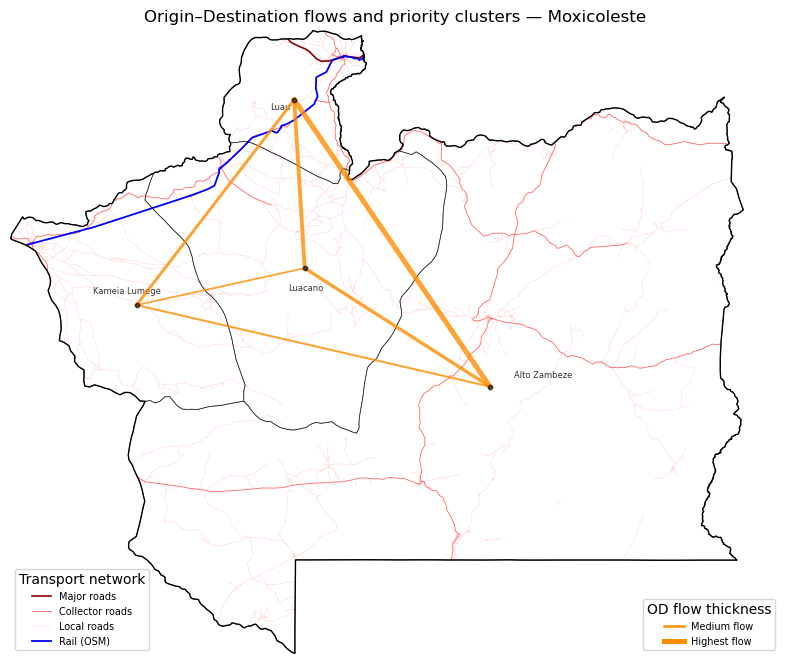

In [14]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.lines import Line2D
from pathlib import Path

from config import AOI, PATHS, PRIORITY_CLUSTERS_TIF, out_t


def make_figure_s5(top_pairs: int = 20,
                   outfile: Path | None = None):
    """
    Build Figure S5 for the current AOI:

    - Reads OD gravity table  → out_t("od_gravity")
    - Reads OD zone attrs     → out_t("od_zone_attrs")
    - Uses zone centroids (lon/lat) as OD nodes
    - Plots:
        * priority clusters raster (Step 11),
        * ADM2/ADM1 boundaries,
        * roads (Major / Collector / Local),
        * railways,
        * top OD pairs as thick arcs (line width ∝ flow).

    Saves to:
        outputs/figs/{AOI}_fig_s5_od_flows.png
    """

    aoi = AOI

    # ------------------------------------------------------------------
    # Load cluster raster (background)
    # ------------------------------------------------------------------
    cluster_raster = Path(PRIORITY_CLUSTERS_TIF)
    if not cluster_raster.exists():
        raise FileNotFoundError(f"Priority clusters raster not found: {cluster_raster}")

    with rasterio.open(cluster_raster) as src:
        arr = src.read(1)
        transform = src.transform
        crs = src.crs
        arr = np.where(np.isfinite(arr) & (arr > 0), arr, np.nan)

    # ------------------------------------------------------------------
    # Vector layers: ADM1, ADM2, roads, rail
    # ------------------------------------------------------------------
    adm1 = gpd.read_file(PATHS.BND_ADM1).to_crs(crs)
    adm2 = gpd.read_file(PATHS.BND_ADM2).to_crs(crs)
    roads = gpd.read_file(PATHS.ROADS).to_crs(crs)
    rail = gpd.read_file(PATHS.RAIL).to_crs(crs)

    # Classify roads like S1
    if "fclass" in roads.columns:
        f = roads["fclass"].str.lower().fillna("")

        major_classes = {
            "motorway", "motorway_link",
            "trunk", "trunk_link",
            "primary", "primary_link",
        }
        collector_classes = {
            "secondary", "secondary_link",
            "tertiary", "tertiary_link",
        }

        def classify_road(val: str) -> str:
            if val in major_classes:
                return "major"
            if val in collector_classes:
                return "collector"
            return "local"

        roads["road_class"] = f.apply(classify_road)

        roads_major = roads[roads["road_class"] == "major"]
        roads_collector = roads[roads["road_class"] == "collector"]
        roads_local = roads[roads["road_class"] == "local"]
    else:
        roads["road_class"] = "local"
        roads_major = roads.iloc[0:0].copy()
        roads_collector = roads.iloc[0:0].copy()
        roads_local = roads

    # Prepare ADM2 label points
    if "NAM_2" in adm2.columns:
        adm2["label_point"] = adm2.geometry.representative_point()

    # ------------------------------------------------------------------
    # OD + zone attributes
    # ------------------------------------------------------------------
    od_path = Path(out_t("od_gravity"))
    attrs_path = Path(out_t("od_zone_attrs"))

    if not od_path.exists():
        raise FileNotFoundError(f"OD gravity table not found: {od_path}")
    if not attrs_path.exists():
        raise FileNotFoundError(f"OD zone attributes table not found: {attrs_path}")

    od = pd.read_csv(od_path)
    attrs = pd.read_csv(attrs_path)

    # basic schema
    needed_od = {"oi", "dj", "flow"}
    if not needed_od.issubset(od.columns):
        raise ValueError(f"{od_path} missing columns {needed_od - set(od.columns)}")

    if "ADM2CD_c" not in attrs.columns or "NAM_2" not in attrs.columns:
        raise ValueError(
            f"{attrs_path} must contain 'ADM2CD_c' and 'NAM_2'. "
            f"Found columns: {list(attrs.columns)}"
        )

    od["oi"] = od["oi"].astype(str)
    od["dj"] = od["dj"].astype(str)
    attrs["ADM2CD_c"] = attrs["ADM2CD_c"].astype(str)

    # Build GeoDataFrame of OD zones (centroids)
    g_zones = gpd.GeoDataFrame(
        attrs[["ADM2CD_c", "NAM_2"]].copy(),
        geometry=gpd.points_from_xy(attrs["lon"], attrs["lat"]),
        crs="EPSG:4326",
    ).to_crs(crs)

    # Map from zone id → geometry
    geom_map = g_zones.set_index("ADM2CD_c")["geometry"].to_dict()

    # Drop self-pairs
    od = od[od["oi"] != od["dj"]].copy()

    # Collapse to undirected pairs and aggregate flow
    od["pair_min"] = od[["oi", "dj"]].min(axis=1)
    od["pair_max"] = od[["oi", "dj"]].max(axis=1)

    flows = (
        od.groupby(["pair_min", "pair_max"], as_index=False)
          .agg(flow=("flow", "sum"), oi=("oi", "first"), dj=("dj", "first"))
    )

    # Keep only pairs where both zones have coordinates
    def has_geoms(row):
        return (row["oi"] in geom_map) and (row["dj"] in geom_map)

    flows = flows[flows.apply(has_geoms, axis=1)].copy()

    if flows.empty:
        raise RuntimeError("No OD pairs with valid zone geometries to plot.")

    flows = flows.sort_values("flow", ascending=False).head(top_pairs).copy()
    f_max = flows["flow"].max()

    # Normalised flow (0..1) for line widths
    flows["flow_norm"] = flows["flow"] / f_max

    # ------------------------------------------------------------------
    # Plot
    # ------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 8))

    # Priority clusters raster
    show(arr, transform=transform, ax=ax, cmap="OrRd", interpolation="nearest", zorder=1)

    # Roads
    if not roads_local.empty:
        roads_local.plot(ax=ax, linewidth=0.3, color="#ffcccc", zorder=2)
    if not roads_collector.empty:
        roads_collector.plot(ax=ax, linewidth=0.6, color="#ff6666", zorder=3)
    if not roads_major.empty:
        roads_major.plot(ax=ax, linewidth=1.2, color="#8b0000", zorder=4)

    # Rail
    if not rail.empty:
        rail.to_crs(crs).plot(ax=ax, linewidth=1.3, color="blue", zorder=5)

    # Admin boundaries
    adm2.boundary.plot(ax=ax, linewidth=0.5, color="black", alpha=0.7, zorder=6)
    adm1.boundary.plot(ax=ax, linewidth=1.0, color="black", zorder=7)

    # Admin2 labels
    if "label_point" in adm2.columns:
        for _, row in adm2.iterrows():
            x, y = row["label_point"].x, row["label_point"].y
            name = str(row["NAM_2"])
            ax.text(
                x,
                y,
                name,
                fontsize=6,
                ha="center",
                va="center",
                color="black",
                alpha=0.8,
                zorder=8,
            )

    # OD arcs
    for _, r in flows.iterrows():
        g_o = geom_map[r["oi"]]
        g_d = geom_map[r["dj"]]
        x0, y0 = g_o.x, g_o.y
        x1, y1 = g_d.x, g_d.y

        lw = 0.6 + 3.0 * float(r["flow_norm"])  # thickness ∝ flow
        ax.plot(
            [x0, x1],
            [y0, y1],
            color="darkorange",
            linewidth=lw,
            alpha=0.8,
            zorder=9,
        )

    # OD zone centroids (small black dots)
    g_zones.plot(ax=ax, markersize=10, color="black", alpha=0.6, zorder=10)

    ax.set_title(f"Origin–Destination flows and priority clusters — {aoi.capitalize()}")
    ax.set_axis_off()

    # Legend for transport network (like S1/S4)
    transport_handles = [
        Line2D([0], [0], color="#8b0000", lw=1.2, label="Major roads"),
        Line2D([0], [0], color="#ff6666", lw=0.6, label="Collector roads"),
        Line2D([0], [0], color="#ffcccc", lw=0.3, label="Local roads"),
        Line2D([0], [0], color="blue", lw=1.3, label="Rail (OSM)"),
    ]

    # Legend for OD flows (line width)
    mid_flow = 0.4 * f_max
    example_flows = [mid_flow, f_max]
    flow_labels = ["Medium flow", "Highest flow"]

    flow_handles = []
    for val, lab in zip(example_flows, flow_labels):
        norm = val / f_max
        lw = 0.6 + 3.0 * float(norm)
        flow_handles.append(Line2D([0], [0], color="darkorange", lw=lw, label=lab))

    leg1 = ax.legend(
        handles=transport_handles,
        title="Transport network",
        loc="lower left",
        fontsize=7,
        frameon=True,
    )

    leg2 = ax.legend(
        handles=flow_handles,
        title="OD flow thickness",
        loc="lower right",
        fontsize=7,
        frameon=True,
    )
    ax.add_artist(leg1)

    fig.tight_layout()

    if outfile is None:
        outfile = PATHS.OUT_F / f"{aoi}_fig_s5_od_flows.png"
    outfile = Path(outfile)
    outfile.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(outfile, dpi=300, bbox_inches="tight")
    print("Saved Figure S5 map →", outfile)

    plt.show()
    return fig, ax


# Example run for current AOI (e.g. Huambo)
fig_s5, ax_s5 = make_figure_s5(top_pairs=20)
